# Get data

In [2]:
import warnings 
import numpy as np

warnings.filterwarnings("ignore")

## Retrieve the data from S3

In [3]:
from common_tools.aws.s3 import S3Client
import pandas as pd 
s3_client = S3Client()
data_path = s3_client.download_file('seloger-data-developers-dev','alaborde/data/data_query_20200220.csv')
data = pd.read_csv(data_path)

## Retrieve the ref_geo from S3

In [4]:
from common_tools.aws.s3 import S3Client
import pandas as pd
s3_client = S3Client()
ref_geo_path = s3_client.download_file('seloger-data-developers-dev','alaborde/data/ref_geo.csv')
ref_geo = pd.read_csv(ref_geo_path)

# Prepare data

In [5]:
data_prep = data[['idannonce','cp','ville','codeinsee','descriptif_fr',
             'px', 'surface','annee_construct','nb_pieces', 'latitude', 'longitude']].copy()

## Ads localization

### Geo mapper CP --> City

In [6]:
key_city = ['city_name','city_id','city_code_insee_sl']
geomap_cp = ref_geo.drop_duplicates(subset=key_city).dropna(subset=key_city)[key_city]
geomap_cp = geomap_cp.rename(columns={'city_code_insee_sl': 'codeinsee'})

In [7]:
data_prep_code_insee = data_prep.merge(geomap_cp, how='left',on=['codeinsee'])
data_prep_code_insee = data_prep_code_insee.rename(columns={
    "city_name": "city_name_by_code_insee",
    "city_id": 'city_id_by_code_insee'
})

### Project in Polygon

In [8]:
import sys
sys.path.append('/home/jeanchristophe/codeFolder/sl_data-science-models/pricemap/src')
sys.path.append('/home/jeanchristophe/codeFolder/sl_data-science-models/priceml/src')
from pricemap.localization.looker import PolygonLookup
from pricemap.localization.utils import looker_dict, build_geo_mapper
from pricemap.filter.filters import lat_long_filter

iris_dict, _, _ = looker_dict(ref_geo)
iris_lookup = PolygonLookup(iris_dict)

In [9]:
def localize(df: pd.DataFrame,
             looker_iris: PolygonLookup,
             ref_geo: pd.DataFrame) -> pd.DataFrame:
    df_to_localize = df.copy()
    df_to_localize.index.name = 'index'
    geo_map_iris, _, geo_map_city = build_geo_mapper(ref_geo)
    # Get dataframe with lat/lon information
    df_with_latlon = df_to_localize.dropna(subset=['latitude', 'longitude']).copy()

    # Look at the IRIS level
    iris_id_from_latlon = looker_iris.lookup(df_with_latlon[['latitude', 'longitude']])
    # Get projection table iris_id => dataframe index
    index_to_id_iris = iris_id_from_latlon.to_frame().dropna()
    index_to_id_iris.columns = ['iris_id']
    index_to_id_iris.index.name = 'index'
    # Merge dataframe with district id
    dataframe_with_idiris = df_to_localize.merge(index_to_id_iris, how='right', on='index')
    # And add the geo info
    geo_map_iris['iris_id'] = geo_map_iris['iris_id'].astype(int)
    dataframe_with_idiris = dataframe_with_idiris.merge(geo_map_iris, how='left', on='iris_id')
    return dataframe_with_idiris

In [10]:
data_prep_code_insee_filt = lat_long_filter(data_prep_code_insee, 'latitude', 'longitude', False)
data_loc = localize(data_prep_code_insee_filt, iris_lookup, ref_geo)

In [11]:
geomap_cp_bis = geomap_cp.rename(columns={"codeinsee": "city_code_insee_sl",
                                         'city_id': 'city_id_from_latlon'})
data_loc = data_loc.merge(geomap_cp_bis, how='left', on=['city_code_insee_sl'])

In [12]:
data_localized = pd.concat([data_loc, data_prep_code_insee_filt], sort=False).drop_duplicates(subset=['idannonce'], keep='first')

In [13]:
districts_mapper = ref_geo.dropna(subset=['districts_id','districts_name']).drop_duplicates(subset=['districts_id','districts_name'])
districts_mapper = districts_mapper[['districts_id','districts_name']].copy()

In [14]:
data_localized_keep = data_localized[(data_localized['city_id_by_code_insee'] ==data_localized['city_id_from_latlon'])
              | (data_localized['city_id_from_latlon'].isna())]
data_localized_keep = data_localized_keep.merge(districts_mapper, how='left', on=['districts_id'])
data_localized_keep = data_localized_keep.drop(columns=['city_name', 'city_id_from_latlon','iris_id',
                                                       'department_id','region_id','country_id'])
data_loc = data_localized_keep.rename(columns={
    "city_name_by_code_insee": 'city_name',
    'city_id_by_code_insee': 'city_id',
    
}).copy()

In [15]:
data_loc

,idannonce,cp,ville,codeinsee,descriptif_fr,px,surface,annee_construct,nb_pieces,latitude,longitude,city_name,city_id,districts_id,city_code_insee_sl,districts_name
0,153921147,83270,Saint Cyr sur Mer,830112.0,Les Lecques - en première ligne - proche mer e...,300000.0,37.70,NaN,2.0,43.179253,5.688592,Saint-Cyr-sur-Mer,35973.0,46103.0,830112.0,Les Lecques-Banette-Bourrasque-Pradeaux
1,149065527,83700,Saint Raphael,830118.0,L'agence WF KING de Valescure vous propose dan...,277000.0,55.00,2018.0,2.0,43.418758,6.796278,Saint-Raphaël,35979.0,46123.0,830118.0,Boulouris
2,146323453,78610,Saint-Leger-en-Yvelines,780562.0,Venez découvrir à mes côtés ce bien rare et at...,170000.0,57.00,1800.0,3.0,48.721718,1.764741,Saint-Léger-en-Yvelines,34117.0,NaN,780562.0,NaN
3,152749001,93140,Bondy,930010.0,Situé dans le nouvel éco quartier de Bondy en ...,213218.0,43.00,NaN,2.0,48.903725,2.485260,Bondy,38353.0,47200.0,930010.0,Le Saule Blanc
4,154493689,69100,Villeurbanne,690266.0,"Château Gaillard, en étage élevé d'une future ...",498000.0,95.82,2021.0,4.0,45.773087,4.889020,Villeurbanne,30327.0,44571.0,690266.0,Les Poulettes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,152667559,69330,Meyzieu,690282.0,Appartement 4 pièces d'environ 66m² à vendre s...,103000.0,66.00,NaN,4.0,NaN,NaN,Meyzieu,30343.0,NaN,NaN,NaN
95408,152582881,01200,Lancrans,10205.0,Joli appartement de 84 m² situé au centre de l...,135000.0,84.00,1940.0,3.0,NaN,NaN,Lancrans,559.0,NaN,NaN,NaN
95409,153475491,33000,Bordeaux,330063.0,Entre Chartrons et Quinconces.Dans petites cop...,560000.0,74.00,NaN,3.0,NaN,NaN,Bordeaux,13950.0,NaN,NaN,NaN
95410,153486885,78100,St Germain en Laye,780551.0,"ST GERMAIN Centre 5'RER, Calme Dans résidence ...",777000.0,97.37,NaN,4.0,NaN,NaN,Saint-Germain-en-Laye,34112.0,NaN,NaN,NaN


## Save it locally

In [16]:
import pickle
with open('/home/jeanchristophe/dataFolder/ppty_goldset/request_ads_2019_2020_iris_localized.pickle','wb') as handle:
    pickle.dump(data_loc, handle)

# Load it locally

In [17]:
import pickle
with open('/home/jeanchristophe/dataFolder/ppty_goldset/request_ads_2019_2020_iris_localized.pickle','rb') as handle:
    data_loc = pickle.load(handle)

In [18]:
data_loc.columns

Index(['idannonce', 'cp', 'ville', 'codeinsee', 'descriptif_fr', 'px',
       'surface', 'annee_construct', 'nb_pieces', 'latitude', 'longitude',
       'city_name', 'city_id', 'districts_id', 'city_code_insee_sl',
       'districts_name'],
      dtype='object')

## Focus on Montpellier area

In [19]:
# Get department id
ref_geo[ref_geo.department_name=='Hérault'].dropna(subset=['department_id']).drop_duplicates('department_name')\
[['department_id','department_name']]

,department_id,department_name
12488,297,Hérault


In [20]:
# Get bordering cities
list_id_bordering_montpellier = eval(ref_geo[ref_geo.city_name=='Montpellier'].dropna(subset=['city_id']).drop_duplicates('city_id')\
['city_bordering'].values[0])
list_id_montpellier = list_id_bordering_montpellier + list(ref_geo[ref_geo.city_name=='Montpellier'].dropna(subset=['city_id']).drop_duplicates('city_id')\
[['city_id']].values[0])
list_id_montpellier

[14512,
 14532,
 14571,
 14578,
 14584,
 14589,
 14609,
 14624,
 14695,
 14702,
 14725,
 14627]

In [21]:
# Filter in Montpellier
df_montpellier = data_loc[data_loc.city_id.isin(list_id_montpellier)].copy()
f'{df_montpellier.shape[0]} ads for Montpellier area'

'1938 ads for Montpellier area'

## Focus on Grenoble area

In [22]:
# Get bordering cities
list_id_bordering_grenoble= eval(ref_geo[ref_geo.city_name=='Grenoble'].dropna(subset=['city_id']).drop_duplicates('city_id')\
['city_bordering'].values[0])
list_id_grenoble = list_id_bordering_grenoble + list(ref_geo[ref_geo.city_name=='Grenoble'].dropna(subset=['city_id']).drop_duplicates('city_id')\
[['city_id']].values[0])
list_id_grenoble

[15838, 15845, 15854, 16058, 16096, 16098, 16146, 16155, 16156, 16182, 15869]

In [23]:
# Filter in Grenoble
df_grenoble = data_loc[data_loc.city_id.isin(list_id_grenoble)].copy()
f'{df_grenoble.shape[0]} ads for Grenoble area'

'882 ads for Grenoble area'

## Focus on Paris

In [24]:
# Get bordering cities
list_id_bordering_paris18 = eval(ref_geo[ref_geo.city_name=='Paris 18ème'].dropna(subset=['city_id']).drop_duplicates('city_id')\
['city_bordering'].values[0])
list_id_paris18 = list_id_bordering_paris18 + list(ref_geo[ref_geo.city_name=='Paris 18ème'].dropna(subset=['city_id']).drop_duplicates('city_id')\
[['city_id']].values[0])
list_id_paris18

[32588, 32589, 32590, 32597, 32599, 38348, 38379, 38380, 32598]

In [25]:
# Filter in Paris 18eme
df_paris18 = data_loc[data_loc.city_id.isin(list_id_paris18)].copy()
f'{df_paris18.shape[0]} ads for Paris 18eme area'

'968 ads for Paris 18eme area'

# Gold set

In [26]:
goldset = pd.concat([df_paris18, df_grenoble, df_montpellier], sort=False)

## Export goldset

In [27]:
goldset.to_csv('/home/jeanchristophe/dataFolder/ppty_goldset/dedup_goldset.csv', index=False)

# Text preprocessing 

In [28]:
import pandas as pd
goldset = pd.read_csv('/home/jeanchristophe/dataFolder/ppty_goldset/dedup_goldset.csv')

In [29]:
from pricemap.filter.filters import simple_text
df_goldset_simpletxt = simple_text(goldset, 'descriptif_fr')

In [30]:
data_goldset = df_goldset_simpletxt.copy()

# Find similar ads

In [31]:
# Group ads that are around the three targeted area
# Method: project in ref geo to get the department and group the ads

group_mapper= ['city_id','region_id']
depart_mapper = ref_geo.drop_duplicates(subset=group_mapper).dropna(subset=group_mapper)[group_mapper]

In [32]:
data_goldset_depart_code = data_goldset.merge(depart_mapper, how='left', on=['city_id'])
data_goldset_depart_code.region_id.value_counts()                      

240    1938
239     968
252     882
Name: region_id, dtype: int64

In [33]:
def group_function(df, delta_price, delta_surface, delta_piece):
    # Delta price of 5%
    # Create max and min bound for each price
    df['min_px'] = df.px*(1-(delta_price/100))
    df['max_px'] = df.px*(1+(delta_price/100))
    
    # Create max and min bound for each price
    df['min_surface'] = df.surface*(1-(delta_surface/100))
    df['max_surface'] = df.surface*(1+(delta_surface/100))

    df['min_nbpiece'] = df.nb_pieces-delta_nbpiece
    df['max_nbpiece'] = df.nb_pieces+delta_nbpiece
    
    piece_matrix= np.zeros((df.shape[0], df.shape[0]))
    surface_matrix= np.zeros((df.shape[0], df.shape[0]))
    price_matrix= np.zeros((df.shape[0], df.shape[0]))
    
    for i in range(df.shape[0]):
        id_groups = np.where((df.nb_pieces >= df.iloc[i]['min_nbpiece']) & (df.nb_pieces <= df.iloc[i]['max_nbpiece']))
        piece_matrix[i, id_groups] = 1
        id_groups = np.where((df.surface >= df.iloc[i]['min_surface']) & (df.surface <= df.iloc[i]['max_surface']))
        surface_matrix[i, id_groups] = 1
        id_groups = np.where((df.px >= df.iloc[i]['min_px']) & (df.px <= df.iloc[i]['max_px']))
        price_matrix[i, id_groups] = 1
    
    combined_matrix = np.multiply(np.multiply(piece_matrix, surface_matrix), price_matrix)
    df['groups'] = 'nan'
    df['len_group'] = 0
    # Get groups
    for i in range(combined_matrix.shape[0]):
        index_list = df.index[np.where(combined_matrix[i,:])[0].tolist()].tolist()
        get_index = df.index[i]
        if get_index in index_list:
            index_list.remove(get_index)
        id_annoncegroup = df.loc[index_list]['idannonce'].values.tolist()
        df.at[get_index, 'groups'] = str(id_annoncegroup)
        df.at[get_index, 'len_group'] = len(id_annoncegroup)
    return df



In [34]:
df_montpellier = data_goldset_depart_code[data_goldset_depart_code.region_id == 240].copy()
df_paris18 = data_goldset_depart_code[data_goldset_depart_code.region_id == 239].copy()
df_grenoble= data_goldset_depart_code[data_goldset_depart_code.region_id == 252].copy()

### Paris

In [35]:
def get_len(row):
    return len(eval(row['groups']))

In [36]:
delta_price = 3.5
delta_surface = 3
delta_nbpiece = 1

groupped_paris18 = group_function(df_paris18, delta_price, delta_surface, delta_nbpiece)


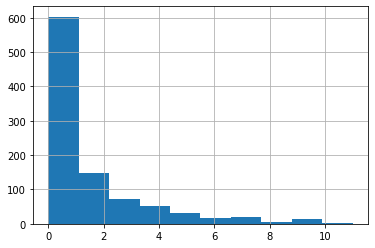

In [37]:
groupped_paris18.apply(get_len, axis = 1).hist()

In [38]:
print(np.sum(groupped_paris18.apply(get_len, axis = 1) == 0), 'idannonce in paris18 has 0 propositions')
print(np.mean(groupped_paris18.apply(get_len, axis = 1)), 'mean number of propositions in paris18')
print(max(groupped_paris18.apply(get_len, axis = 1)), 'max number of proposition in paris18')

378 idannonce in paris18 has 0 propositions
1.6167355371900827 mean number of propositions in paris18
11 max number of proposition in paris18


In [39]:
groupped_paris18.head()

,idannonce,cp,ville,codeinsee,descriptif_fr,px,surface,annee_construct,nb_pieces,latitude,...,districts_name,region_id,min_px,max_px,min_surface,max_surface,min_nbpiece,max_nbpiece,groups,len_group
0,149176331,75009,Paris 9ème,750109.0,exclusivite metros st georges notre dame de lo...,550000.0,42.0,1840.0,2.0,48.879756,...,Lorette-Martyrs,239,530750.0,569250.0,40.74,43.26,1.0,3.0,[],0
1,145083607,75019,Paris 19ème,750119.0,proche des buttes chaumont avenue mathurin mor...,950000.0,84.0,NaN,4.0,48.878746,...,Secrétan,239,916750.0,983250.0,81.48,86.52,3.0,5.0,[],0
2,153334381,75008,Paris 8ème,750108.0,a pas de la gare saint lazare chambre au eme e...,90000.0,6.0,NaN,1.0,48.879645,...,Europe,239,86850.0,93150.0,5.82,6.18,0.0,2.0,[150772943],1
3,149940713,75008,Paris 8ème,750108.0,l etoile real estate vous suggeres un appartem...,3150000.0,180.0,NaN,5.0,48.871872,...,Elysées-Madeleine,239,3039750.0,3260250.0,174.60,185.40,4.0,6.0,[150937503],1
4,151177031,93200,Saint-Denis,930066.0,au premier etage d un immeuble donnant sur le ...,250000.0,68.0,1978.0,3.0,48.936399,...,Centre Ville-Basilique,239,241250.0,258750.0,65.96,70.04,2.0,4.0,[],0


### Montpellier

In [81]:
delta_price = 2
delta_surface = 2
delta_nbpiece = 1

groupped_montpellier = group_function(df_montpellier, delta_price, delta_surface, delta_nbpiece)

In [82]:
print(len(groupped_montpellier['idannonce'].unique()), 'idannonce in Montpellier')
print(np.sum(groupped_montpellier.apply(get_len, axis = 1) == 0), 'idannonce in Montpellier has 0 propositions')
print(np.mean(groupped_montpellier.apply(get_len, axis = 1)), 'mean number of propositions in Montpellier')
print(max(groupped_montpellier.apply(get_len, axis = 1)), 'max number of proposition in Montpellier')

1938 idannonce in Montpellier
506 idannonce in Montpellier has 0 propositions
2.4401444788441693 mean number of propositions in Montpellier
18 max number of proposition in Montpellier


In [83]:
groupped_montpellier.head()

,idannonce,cp,ville,codeinsee,descriptif_fr,px,surface,annee_construct,nb_pieces,latitude,...,districts_name,region_id,min_px,max_px,min_surface,max_surface,min_nbpiece,max_nbpiece,groups,len_group
1850,153882117,34000,Montpellier,340172.0,pres d arenes t de m a deux pas du centre hist...,196000.0,49.0,NaN,2.0,43.604727,...,Port Marianne,240,192080.00,199920.00,48.02,49.98,1.0,3.0,"[152838137, 153433453]",2
1851,137167811,34000,Montpellier,340172.0,au premier etage d une residence securisee t d...,138112.0,46.0,NaN,2.0,43.604727,...,Port Marianne,240,135349.76,140874.24,45.08,46.92,1.0,3.0,[],0
1852,153356669,34000,Montpellier,340172.0,herault a vendre a montpellier dans le secteur...,229000.0,106.0,1970.0,4.0,43.604727,...,Port Marianne,240,224420.00,233580.00,103.88,108.12,3.0,5.0,"[153217207, 151328671]",2
1853,154506007,34000,Montpellier,340172.0,appartement d exception dans residence haut de...,650000.0,93.0,NaN,4.0,43.604727,...,Port Marianne,240,637000.00,663000.00,91.14,94.86,3.0,5.0,[153207129],1
1854,153597569,34430,Saint Jean de Vedas,340270.0,st jean de vedas proche de l a de la station d...,399000.0,110.0,2018.0,4.0,43.568759,...,Sud,240,391020.00,406980.00,107.80,112.20,3.0,5.0,[],0


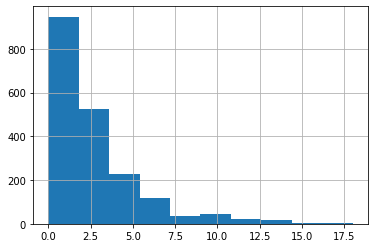

In [84]:
groupped_montpellier.len_group.hist()

### Grenoble

In [77]:
delta_price = 3
delta_surface = 2
delta_nbpiece = 1

groupped_grenoble = group_function(df_grenoble, delta_price, delta_surface, delta_nbpiece)

In [78]:
print(len(groupped_grenoble['idannonce'].unique()), 'idannonce in Grenoble')
print(np.sum(groupped_grenoble.apply(get_len, axis = 1) == 0), 'idannonce in Grenoble has 0 propositions')
print(np.mean(groupped_grenoble.apply(get_len, axis = 1)), 'mean number of propositions in Grenoble')
print(max(groupped_grenoble.apply(get_len, axis = 1)), 'max number of proposition in Grenoble')

882 idannonce in Grenoble
253 idannonce in Grenoble has 0 propositions
1.9160997732426304 mean number of propositions in Grenoble
12 max number of proposition in Grenoble


In [79]:
groupped_grenoble.head()

,idannonce,cp,ville,codeinsee,descriptif_fr,px,surface,annee_construct,nb_pieces,latitude,...,districts_name,region_id,min_px,max_px,min_surface,max_surface,min_nbpiece,max_nbpiece,groups,len_group
968,152917265,38100,Grenoble,380185.0,grenoble allee de la pelouse en bordure du par...,88000.0,80.08,NaN,4.0,45.162621,...,Arlequin,252,85360.0,90640.0,78.4784,81.6816,3.0,5.0,"[137918345, 152656465, 154105923]",3
969,151210099,38100,Grenoble,380185.0,era immobilier gresivaudan a trouve pour vous ...,158970.0,70.00,1960.0,3.0,45.180660,...,Allies-Clos d'Or,252,154200.9,163739.1,68.6000,71.4000,2.0,4.0,[142827435],1
970,150907823,38130,Échirolles,380151.0,iad france sophie armand vous propose echiroll...,125000.0,63.00,1970.0,4.0,45.147226,...,Comboire,252,121250.0,128750.0,61.7400,64.2600,3.0,5.0,"[151785547, 152595879, 154223735]",3
971,148550245,38000,Grenoble,380185.0,appartement residence etudiante marie curie de...,67000.0,18.00,NaN,1.0,45.194349,...,Berriat-Ampere,252,64990.0,69010.0,17.6400,18.3600,0.0,2.0,[],0
972,152658935,38400,Saint Martin d Heres,380421.0,secteur parc jo blanchon au calme et proche tr...,199000.0,99.00,NaN,6.0,45.173628,...,Renaudie-La Plaine,252,193030.0,204970.0,97.0200,100.9800,5.0,7.0,[],0


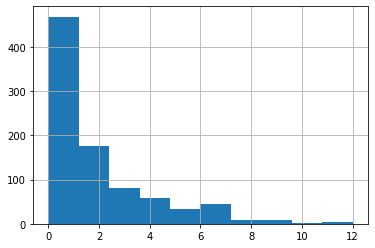

In [80]:
groupped_grenoble.len_group.hist()

### Checks if idannonce is unique

In [85]:
print(groupped_paris18.set_index('idannonce').index.is_unique)
print(groupped_montpellier.set_index('idannonce').index.is_unique)
print(groupped_grenoble.set_index('idannonce').index.is_unique)

True
True
True


### Saving

In [86]:
def get_group_list(df, min_len, max_len):
    df_filtered = df[(df.len_group >= min_len) & (df.len_group <= max_len)].copy()
    list_group = []
    for _, row in df_filtered.iterrows():
        group = [row.idannonce] + eval(row.groups)
        list_group.append(group)
    return list_group
    

In [91]:
# Groups on Paris
list_of_groups = get_group_list(groupped_paris18, 2, 20)
list_idannonce_flat = [item for sublist in list_of_groups for item in sublist]
list_ids_paris = list(set(list_idannonce_flat))
f'{len(list_ids_paris)} idannonce in Paris'

'422 idannonce in Paris'

In [92]:
# Groups on Motnpellier
list_of_groups = get_group_list(groupped_montpellier, 2, 20)
list_idannonce_flat = [item for sublist in list_of_groups for item in sublist]
list_ids_montpellier = list(set(list_idannonce_flat))
f'{len(list_ids_montpellier)} idannonce in Montpellier'

'1133 idannonce in Montpellier'

In [93]:
# Groups on Motnpellier
list_of_groups = get_group_list(groupped_grenoble, 2, 20)
list_idannonce_flat = [item for sublist in list_of_groups for item in sublist]
list_ids_grenoble = list(set(list_idannonce_flat))
f'{len(list_ids_grenoble)} idannonce in Grenoble'

'496 idannonce in Grenoble'

In [94]:
list_ids_annotation = list_ids_paris + list_ids_montpellier + list_ids_grenoble
len(list_ids_annotation)

2051

In [95]:
import json
with open('/home/jeanchristophe/dataFolder/ppty_goldset/idannonce_dedup.json', 'w') as handle:
    json.dump(list_ids_annotation, handle)

In [96]:
groups_goldataset = pd.concat([groupped_grenoble, groupped_montpellier, groupped_paris18], sort=False)

In [97]:
groupped_paris18.len_group.describe()

count    968.000000
mean       1.616736
std        2.065326
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: len_group, dtype: float64

In [98]:
groups_goldataset.len_group.describe()

count    3788.000000
mean        2.107709
std         2.480665
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        18.000000
Name: len_group, dtype: float64

In [99]:
groups_goldataset.to_csv('/home/jeanchristophe/dataFolder/ppty_goldset/goldset_dedup_grouped.csv', index=False)

# Check image access

In [100]:
import json
with open('/home/jeanchristophe/dataFolder/ppty_goldset/idannonce_dedup.json', 'r') as handle:
    selected_id_annonce = json.load(handle)

In [ ]:
import pandas as pd
id_photo = pd.read_excel('/home/jeanchristophe/codeFolder/ppty_goldset/data/mapping_id_tag.xlsx')

In [ ]:
id_photo